In [ ]:
import paulssonlab.deaton.trenchripper.trenchripper as tr

import warnings

warnings.filterwarnings(action="once")

import matplotlib

matplotlib.rcParams["figure.figsize"] = [20, 10]

In [1]:
with open("./memefile","r") as infile:
    print(infile)

FileNotFoundError: [Errno 2] No such file or directory: './memefile'

In [19]:
import h5py_cache
import numpy as np

In [ ]:
headpath = "/n/scratch2/de64/2020-03-02_plasmid_loss/"
nd2file = "/n/scratch2/de64/2020-03-02_plasmid_loss/Basilisk_SJC25x2_SJC28_Losses.nd2"

In [7]:
kymoclust = tr.kymograph.kymograph_cluster(
    headpath=headpath, trenches_per_file=25,paramfile=True
)

In [8]:
fovdf = kymoclust.meta_handle.read_df("global",read_metadata=True)
kymoclust.metadata = fovdf.metadata

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [9]:
trench_edges_y_list = []
for f in range(6):
    smoothed_y = kymoclust.get_smoothed_y_percentiles(0,kymoclust.y_percentile,kymoclust.smoothing_kernel_y)
    trench_edges_y = kymoclust.get_trench_edges_y(smoothed_y,kymoclust.y_percentile_threshold,kymoclust.y_min_edge_dist)
    trench_edges_y_list.append(trench_edges_y)

In [10]:
working_fovdf = fovdf.loc[0]
working_files = working_fovdf["File Index"].unique().tolist()

In [11]:
working_files

[0, 1, 2, 3, 4, 5]

In [12]:
drift_orientation_and_initend = kymoclust.get_ends_and_orientations(0,trench_edges_y_list,kymoclust.expected_num_rows,kymoclust.alternate_orientation,\
                                                       kymoclust.top_orientation,kymoclust.orientation_on_fail,kymoclust.y_min_edge_dist,kymoclust.padding_y,kymoclust.trench_len_y)

In [13]:
drift_orientation_and_initend

(array([ 0,  1,  0,  0,  0, -1, -1, -1,  0, -1, -1,  0,  0,  0,  1,  2,  2,
         2,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  2,  2,  2,  2,  3,
         3,  3,  2,  2,  2,  3,  3,  3,  2,  3,  2,  2,  2,  1,  1,  1,  1,
         2,  1,  1,  1,  0,  0,  0,  1,  0,  0,  1,  1,  1,  2,  3,  3,  3,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  3,  3,  3,  3,  4,  4,
         4,  3,  3,  3,  4,  4,  4,  3,  4,  3,  3,  3,  2,  2,  2,  2,  3,
         2,  2,  2,  1,  1,  1,  2,  1,  1,  2,  2,  2,  3,  4,  4,  4,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  4,  4,  4,  4,  5,  5,  5,
         4,  4,  4,  5,  5,  5,  4,  5,  4,  4,  4,  3,  3,  3,  3,  4,  3,
         3,  3,  2,  2,  2,  3,  2,  2,  3,  3,  3,  4,  5,  5,  5,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  6,  6,  5,  5,  5,  5,  6,  6,  6,  5,
         5,  5,  6,  6,  6,  5,  6,  5,  5,  5,  4,  4,  4,  4,  5,  4,  4,
         4,  3,  3,  3,  4,  3,  3,  4,  4,  4,  5,  6,  6,  6,  5,  5,  5,
         5, 

In [14]:
midpoint_futures_list = []
for f in range(6):
    smoothed_x_future = kymoclust.get_smoothed_x_percentiles(f,drift_orientation_and_initend,kymoclust.padding_y,kymoclust.trench_len_y,kymoclust.x_percentile,kymoclust.background_kernel_x,\
                                                           kymoclust.smoothing_kernel_x)
    midpoint_futures = kymoclust.get_x_midpoints(smoothed_x_future,kymoclust.otsu_scaling,kymoclust.min_threshold)
    midpoint_futures_list.append(midpoint_futures)

In [15]:
x_drift = kymoclust.get_x_drift(midpoint_futures_list)

In [38]:
in_bounds_future = kymoclust.get_all_in_bounds(midpoint_futures_list,x_drift,\
                                                15,kymoclust.trench_present_thr)

In [39]:
fovdf = kymoclust.meta_handle.read_df("global",read_metadata=False)
filedf = fovdf.reset_index(inplace=False)
filedf = filedf.set_index(["File Index","Image Index"], drop=True, append=False, inplace=False)
filedf = filedf.sort_index()
working_filedf = filedf.loc[0]

timepoint_indices = working_filedf["timepoints"].unique().tolist()
image_indices = working_filedf.index.get_level_values("Image Index").unique().tolist()
first_idx,last_idx = (timepoint_indices[0],timepoint_indices[-1])  #CHANGED
channel_arr_list,lane_y_coords_list = kymoclust.crop_y(0,drift_orientation_and_initend,kymoclust.padding_y,kymoclust.trench_len_y)
num_rows = channel_arr_list[0].shape[1]
in_bounds_list,x_coords_list,k_tot_list = in_bounds_future

In [40]:
with h5py_cache.File(kymoclust.kymographpath+"/kymograph_processed_"+str(0)+".hdf5","w",chunk_cache_mem_size=kymoclust.output_chunk_cache_mem_size) as output_kymograph:
    for row_num in range(num_rows):
        in_bounds,k_tot = (in_bounds_list[row_num],k_tot_list[row_num])
        working_in_bounds = in_bounds[:,first_idx:last_idx+1]
#                 kymo_mask = self.get_trench_mask(in_bounds[:,first_idx:last_idx+1],counting_arr)
        kymoclust.crop_with_bounds(output_kymograph,channel_arr_list,working_in_bounds,k_tot,row_num)

In [41]:
import h5py

In [42]:
with h5py.File(kymoclust.kymographpath+"/kymograph_processed_"+str(0)+".hdf5","r") as infile:
    print(infile["0/YFP"].shape)
    data = infile["0/YFP"][:]

(175, 50, 210, 15)


In [43]:
temp = tr.kymo_handle()

In [44]:
temp.import_wrap(data[50])

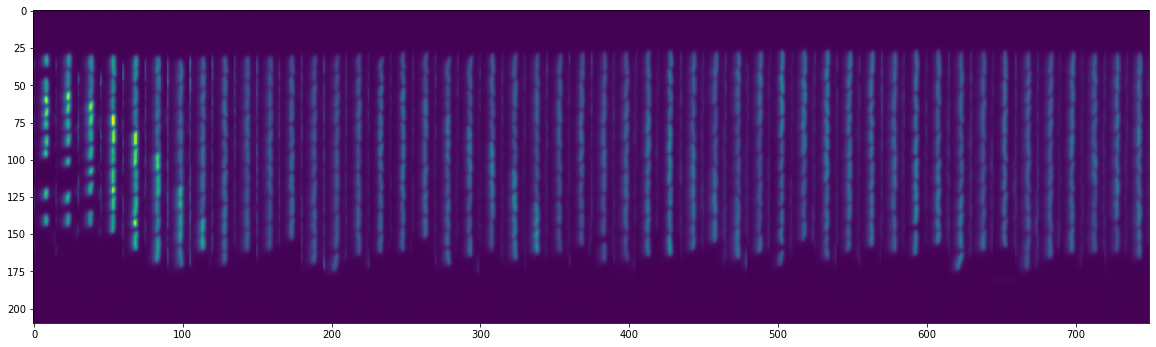

In [45]:
from matplotlib import pyplot as plt
plt.imshow(temp.return_unwrap())

In [58]:
for k in range(in_bounds_list[0].shape[1]):
    for t in range(50):
        bounds = in_bounds_list[0][:,k,t]
        output = channel_arr_list[0][:,0][t,:,bounds[0]:bounds[1]]
        pass

In [ ]:
    def crop_x(self,file_idx,drift_orientation_and_initend_future,in_bounds_future,padding_y,trench_len_y):
        """Generates complete kymograph arrays for all trenches in the fov in
        every channel listed in 'self.all_channels'. Writes hdf5 files
        containing datasets of shape (trench_num,y_dim,x_dim,t_dim) for each
        row,channel combination. Dataset keys follow the convention.

        ["[row_number]/[channel_name]"].

        Args:
            cropped_in_y_handle (h5py.File): Hdf5 file handle corresponding to the y-cropped hdf5 dataset
            "data" of shape (rows,channels,x,y,t).
            all_midpoints_list (list): A nested list of the form [row_list,[time_list,[midpoint_array]]] containing
            the trench midpoints.
            x_drift_list (list): A nested list of the form [row_list,[time_list,[x_drift_int]]] containing the computed
            drift in the x dimension.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        """
        fovdf = self.meta_handle.read_df("global",read_metadata=False)
#         fovdf = fovdf.loc[(slice(None), slice(self.t_range[0],self.t_range[1])),:]
        filedf = fovdf.reset_index(inplace=False)
        filedf = filedf.set_index(["File Index","Image Index"], drop=True, append=False, inplace=False)
        filedf = filedf.sort_index()
        working_filedf = filedf.loc[file_idx]

        timepoint_indices = working_filedf["timepoints"].unique().tolist()
        image_indices = working_filedf.index.get_level_values("Image Index").unique().tolist()
#         first_idx,last_idx = (timepoint_indices[0]-self.t_range[0],timepoint_indices[-1]-self.t_range[0])  #CHANGED
        first_idx,last_idx = (timepoint_indices[0],timepoint_indices[-1])  #CHANGED


        channel_arr_list,lane_y_coords_list = self.crop_y(file_idx,drift_orientation_and_initend_future,padding_y,trench_len_y)
        num_rows = channel_arr_list[0].shape[1]

        in_bounds_list,x_coords_list,k_tot_list = in_bounds_future
        counting_arr = self.init_counting_arr(self.metadata["width"])

        with h5py_cache.File(self.kymographpath+"/kymograph_processed_"+str(file_idx)+".hdf5","w",chunk_cache_mem_size=self.output_chunk_cache_mem_size) as output_kymograph:
            for row_num in range(num_rows):
                in_bounds,k_tot = (in_bounds_list[row_num],k_tot_list[row_num])
                kymo_mask = self.get_trench_mask(in_bounds[:,first_idx:last_idx+1],counting_arr)

                self.crop_with_k_masks(output_kymograph,channel_arr_list,kymo_mask,k_tot,row_num)

        return lane_y_coords_list

In [ ]:
        ### smoothed y percentiles ###

        for k,file_idx in enumerate(file_list):
            future = dask_controller.daskclient.submit(self.get_smoothed_y_percentiles,file_idx,\
                                        self.y_percentile,self.smoothing_kernel_y,retries=1)
            dask_controller.futures["Smoothed Y Percentiles: " + str(file_idx)] = future

        ### get trench row edges, y midpoints ###

        for k,file_idx in enumerate(file_list):
            smoothed_y_future = dask_controller.futures["Smoothed Y Percentiles: " + str(file_idx)]
            future = dask_controller.daskclient.submit(self.get_trench_edges_y,smoothed_y_future,self.y_percentile_threshold,\
                                                       self.y_min_edge_dist,retries=1)

            dask_controller.futures["Y Trench Edges: " + str(file_idx)] = future

        ### get y drift, orientations, init edges ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            edges_futures = [dask_controller.futures["Y Trench Edges: " + str(file_idx)] for file_idx in working_files]
            future = dask_controller.daskclient.submit(self.get_ends_and_orientations,fov_idx,edges_futures,self.expected_num_rows,self.alternate_orientation,\
                                                       self.top_orientation,self.orientation_on_fail,self.y_min_edge_dist,self.padding_y,self.trench_len_y,retries=1)
            dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)] = future

        ### smoothed x percentiles ###

        for k,file_idx in enumerate(file_list):
            working_filedf = filedf.loc[file_idx]
            fov_idx = working_filedf["fov"].unique().tolist()[0]
            drift_orientation_and_initend_future = dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]
            future = dask_controller.daskclient.submit(self.get_smoothed_x_percentiles,file_idx,drift_orientation_and_initend_future,\
                                                       self.padding_y,self.trench_len_y,self.x_percentile,self.background_kernel_x,\
                                                       self.smoothing_kernel_x,retries=1)
            dask_controller.futures["Smoothed X Percentiles: " + str(file_idx)] = future

        ### get x midpoints ###

        for k,file_idx in enumerate(file_list):
            smoothed_x_future = dask_controller.futures["Smoothed X Percentiles: " + str(file_idx)]
            future = dask_controller.daskclient.submit(self.get_x_midpoints,smoothed_x_future,\
                                                       self.otsu_scaling,self.min_threshold,retries=1)
            dask_controller.futures["X Midpoints: " + str(file_idx)] = future

        ### get x drift ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            midpoint_futures = [dask_controller.futures["X Midpoints: " + str(file_idx)] for file_idx in working_files]
            future = dask_controller.daskclient.submit(self.get_x_drift,midpoint_futures,retries=1)
            dask_controller.futures["X Drift: " + str(fov_idx)] = future

        ### get kymograph masks ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            midpoint_futures = [dask_controller.futures["X Midpoints: " + str(file_idx)] for file_idx in working_files]
            x_drift_future = dask_controller.futures["X Drift: " + str(fov_idx)]
            future = dask_controller.daskclient.submit(self.get_all_in_bounds,midpoint_futures,x_drift_future,\
                                                self.trench_width_x,self.trench_present_thr,retries=1)
            dask_controller.futures["X In Bounds: " + str(fov_idx)] = future

        ### crop in x ###


        for k,file_idx in enumerate(file_list):
            working_filedf = filedf.loc[file_idx]
            fov_idx = working_filedf["fov"].unique().tolist()[0]
            drift_orientation_and_initend_future = dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]
            in_bounds_future = dask_controller.futures["X In Bounds: " + str(fov_idx)]

            future = dask_controller.daskclient.submit(self.crop_x,file_idx,drift_orientation_and_initend_future,in_bounds_future,self.padding_y,self.trench_len_y,retries=0)
            dask_controller.futures["X Crop: " + str(file_idx)] = future

        ### get coords ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            x_crop_futures = [dask_controller.futures["X Crop: " + str(file_idx)] for file_idx in working_files]
            in_bounds_future = dask_controller.futures["X In Bounds: " + str(fov_idx)]
            drift_orientation_and_initend_future = dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]

            future = dask_controller.daskclient.submit(self.save_coords,fov_idx,x_crop_futures,in_bounds_future,drift_orientation_and_initend_future,retries=1)#,priority=priority)
            dask_controller.futures["Coords: " + str(fov_idx)] = future